# Homework # 3: Neural Networks
Members: Jack Hanke, Daniel Plotkin, Hanna Zelis, Nicole Birova, & Vrishani Shah

Due: November 19

In [ ]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
%matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T
    # changed to added ones to allign with label data
    # temp = np.ones((data.shape[0], 1))
    # data = np.hstack((data, temp))

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            # pl = torch.argmax(pl, dim=1)
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)


    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

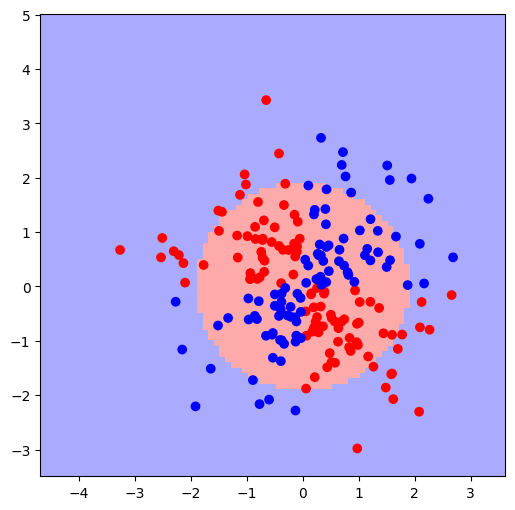

In [86]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import sys
import os
import random

%matplotlib inline

np.random.seed(42)
torch.manual_seed(0)

def read_data(name, mode):
    x_data = []
    y_data = []
    label_data = []

    base_dir = os.getcwd()
    root = base_dir
    filename = '%s/%s_%s.csv' % (root,name,mode)

    i = 0
    with open(filename,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            if i > 0:
                y = int(float(tokens[0]))
                x1 = float(tokens[1])
                x2 = float(tokens[2])
                x_data.append([1.0,x1,x2])
                y_data.append([y])
                temp = [0,0]
                temp[y] = 1
                label_data.append(temp)
            i = i + 1
    # xs = np.array(x_data,dtype='float32')
    # ys = np.array(y_data,dtype='float32')
    # labels = np.array(label_data,dtype='float32')
    xs = torch.Tensor(x_data)
    ys = torch.Tensor(y_data)
    labels = torch.Tensor(label_data)
    return(xs,ys,labels)

class net3(nn.Module):
    def __init__(self,input_size,nodes,output_size):
        super(net3,self).__init__()
#        self.l1 = nn.Linear(input_size,nodes)
#        self.activation = nn.Tanh()

    def forward(self,x):
#        output = self.l1(x)
#        output = self.activation(output)
        a = torch.mul(x[:,1],x[:,1])
        b = torch.mul(x[:,2],x[:,2])
        c = (a+b)/9.0
        output = torch.exp(c)
        return output

def draw_example(nodes,name,model):
    x_train, y_train, label_train = read_data(name,'train')
    x_test, y_test, label_test = read_data(name,'test')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6*(1+0)))

    h = .1  # step size in the mesh
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    y_min, y_max = x_train[:, 2].min() - 1, x_train[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = np.zeros([xx.shape[0],yy.shape[1]],dtype='float32')
    Z2 = np.zeros([nodes,xx.shape[0],yy.shape[1]],dtype='float32')
    grid_data = np.ones([1,3],dtype='float32')

    grid_data2 = np.zeros([1,3],dtype='float32')
    for i in range(xx.shape[0]):
        for j in range(yy.shape[1]):
            x = xx[i,j]
            y = yy[i,j]
            grid_data2[0,0] = 1.0
            grid_data2[0,1] = x
            grid_data2[0,2] = y

            x = torch.from_numpy(grid_data2)
            pred = model(x)
            if (pred[0].item()-6.0) > -4.5:
                yh = 1.0
            else:
                yh = 0.0
            Z[i,j] = yh
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    ax.scatter(x_test[:, 1], x_test[:, 2], c=y_test[:,0], cmap=cmap_bold)
    plt.show()

nodes = 3
name = 'xor'
model = net3(3,nodes,1)
draw_example(nodes,name,model=model)



## Question 1. PyTorch Implementation with MCE (2.0 points)

Implement and train a FFNN as specified above using PyTorch and multi-class cross entropy as the cost function. Experiment with each of the four datasets to find the best number of nodes $k$ from ${2, 3, 5, 7, 9}$ in the hidden layer. For the best $k$ for *each* dataset:

a. list hyper-parameters used in the model,

b. plot the learning curves for training and validation loss as a function of training epochs,

c. provide the final test accuracy, defined as the number of correct classifications divided by the total number of examples,

d. plot the learned decision surface along with observations from the test set (see example below), and

e. discuss your design choices and comment on how they impact performance

## Responses to Question 1

For the `xor` dataset ...

a. TODO

b. View output of below code.

c. View output of below code.

d. TODO

e. TODO

For the `center_surround` dataset ...

a. TODO

b. View output of below code.

c. View output of below code.

d. TODO

e. TODO

For the `two_gaussians` dataset ...

a. TODO

b. View output of below code.

c. View output of below code.

d. TODO

e. TODO

For the `spiral` dataset ...

a. TODO

b. View output of below code.

c. View output of below code.

d. TODO

e. TODO

/var/folders/20/l01njk_d68v9mcxb4mc_1c840000gn/T/ipykernel_6541/2126788855.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  activation_2 = F.softmax(self.layer2(activation_1)) # add argument for dim


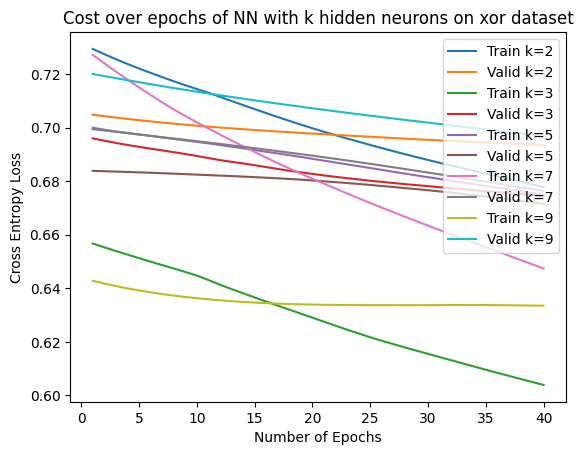

Accuracy for xor dataset for NN with k=9 is 55.00%.
[[-5.   -5.    1.  ]
 [-4.95 -5.    1.  ]
 [-4.9  -5.    1.  ]
 ...
 [ 4.85  4.95  1.  ]
 [ 4.9   4.95  1.  ]
 [ 4.95  4.95  1.  ]]


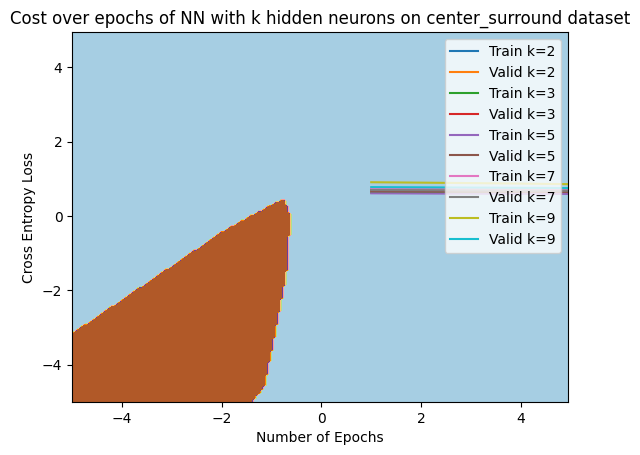

Accuracy for center_surround dataset for NN with k=9 is 50.00%.
[[-5.   -5.    1.  ]
 [-4.95 -5.    1.  ]
 [-4.9  -5.    1.  ]
 ...
 [ 4.85  4.95  1.  ]
 [ 4.9   4.95  1.  ]
 [ 4.95  4.95  1.  ]]


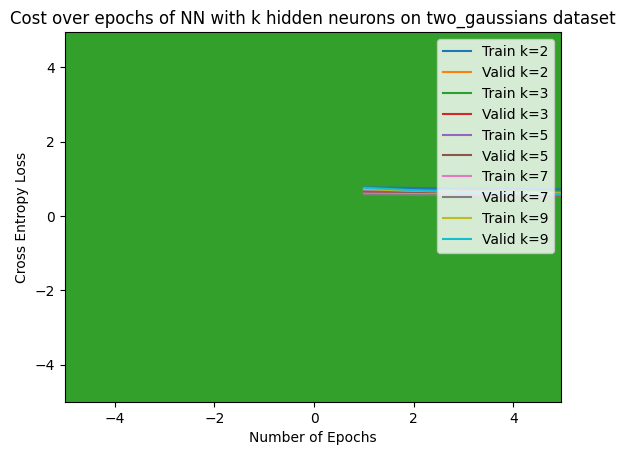

Accuracy for two_gaussians dataset for NN with k=9 is 90.50%.
[[-5.   -5.    1.  ]
 [-4.95 -5.    1.  ]
 [-4.9  -5.    1.  ]
 ...
 [ 4.85  4.95  1.  ]
 [ 4.9   4.95  1.  ]
 [ 4.95  4.95  1.  ]]


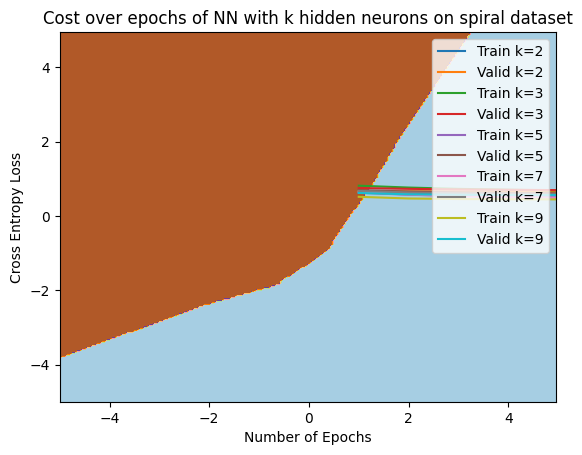

Accuracy for spiral dataset for NN with k=9 is 79.50%.
[[-5.   -5.    1.  ]
 [-4.95 -5.    1.  ]
 [-4.9  -5.    1.  ]
 ...
 [ 4.85  4.95  1.  ]
 [ 4.9   4.95  1.  ]
 [ 4.95  4.95  1.  ]]


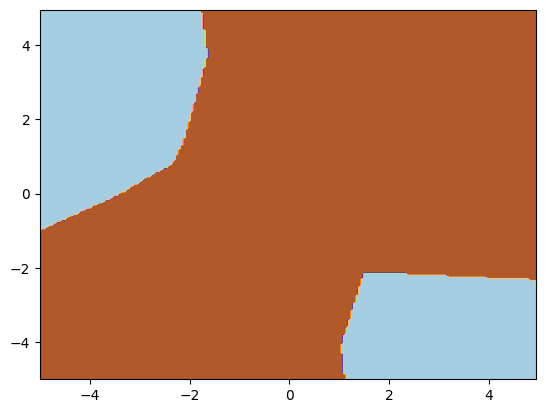

In [85]:
# Question 1

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# set random seed for reproducibility
torch.manual_seed(343)

# define network for Question 1
class Q1_Net(nn.Module):
    def __init__(self,k):
        super(Q1_Net, self).__init__()
        self.layer1 = nn.Linear(3, k, bias=False) # bias is appended to all samples from read_data function
        self.layer2 = nn.Linear(k, 2, bias=False)

    def forward(self, input_vals):
        input_vals = torch.Tensor(input_vals)
        activation_1 = F.relu(self.layer1(input_vals)) # chad relu
        activation_2 = F.softmax(self.layer2(activation_1)) # add argument for dim
        return activation_2

def batchify(data, batch_size):
    data_batched = []
    for k in range(len(data)//batch_size):
        # data_batched.append(torch.Tensor(data[k*batch_size:(k+1)*batch_size]))
        data_batched.append(data[k*batch_size:(k+1)*batch_size])
    return data_batched

datasets = ['xor', 'center_surround', 'two_gaussians', 'spiral']
k_vals = [2,3,5,7,9]
# set hyperparams (globally for all datasets)
learning_rate = 0.01 # hold learning rate steady for all k and all datasets
num_epochs = 40 # number of times each data point is used to update weights
batch_size = 10 # number of data points considered for each iterations of SGD
for dataset in datasets:
    for k_val in k_vals:
        train_cost_history, valid_cost_history = [], []
        # bring in training data
        train_data, train_data_ys, train_data_onehot = read_data(name=dataset, mode='train')
        # instantiate network for specific k_val
        net = Q1_Net(k=k_val)
        # create cost function 
        cost_function = nn.CrossEntropyLoss()
        # create stochastic gradient descent optimizer
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
        # for each epoch
        net.train()
        for epoch in range(1,num_epochs+1):
            # implemenst batch processing
            batched_train_data = batchify(data=train_data, batch_size=batch_size)
            batched_train_data_onehot = batchify(data=train_data_onehot, batch_size=batch_size)
            for batched_data, batched_data_onehot in zip(batched_train_data, batched_train_data_onehot):
                # forward pass
                inferences = net(input_vals=batched_data)
                # computes cost of forward pass
                cost = cost_function(inferences, batched_data_onehot)
                # calculates gradient
                cost.backward()
                # update weights and biases of network
                optimizer.step()
                # zero gradients bc PyTorch docs said so
                optimizer.zero_grad()
            # record training cost per epoch for plotting
            train_cost_history.append(float(cost))

            # get validation data
            valid_data, valid_data_ys, valid_data_onehot = read_data(name=dataset, mode='valid')
            # conduct validation inferences
            validation_inferences = net(input_vals=valid_data)
            # compute validation cost
            cost = cost_function(validation_inferences, valid_data_onehot)
            # record validation cost per epoch for plotting
            valid_cost_history.append(float(cost))
        plt.plot([i for i in range(1,num_epochs+1)], train_cost_history, label=f'Train k={k_val}')
        plt.plot([i for i in range(1,num_epochs+1)], valid_cost_history, label=f'Valid k={k_val}')

    plt.title(f'Cost over epochs of NN with k hidden neurons on {dataset} dataset')
    plt.xlabel(f'Number of Epochs')
    plt.ylabel(f'Cross Entropy Loss')
    plt.legend(loc='upper right')
    plt.show()

    net.eval()
    # get test data
    test_data, test_data_ys, test_data_onehot = read_data(name=dataset, mode='test')
    # conduct test inferences
    test_inferences = torch.argmax(net(input_vals = test_data), dim=1)
    # compute accuracy 
    test_ys = torch.squeeze(test_data_ys)
    acc = ((test_inferences == test_ys).sum())/len(test_data)
    print(f'Accuracy for {dataset} dataset for NN with k={k_val} is {acc*100:.2f}%.')

    # plot decision surface
    plot_decision_surface(model=net)



## Question 2. PyTorch Implementation with MSE (2.0 points)
Repeat Step 1 using mean-squared error as the cost function. You may want to use a sigmoid function as the output layer of your network and apply a threshold of $0.5$ to assign labels at test time.

In [5]:
# TODO code for question 2

## Question 3. Manual Gradients and Updates (3.0 points)
Repeat either Step 1 or Step 2 *without* using a deep learning platform. You can use symbolic differentiation tools like WolramAlpha, Mathematica, etc., to compute gradients. You can also calculate the gradients by hand. You may want to calculate, code and verify gradients for individual components of your model and use the chain rule to build the gradients for specific weights and biases. You may also want to consider using for loops instead of matrix algebra in some parts of your code to avoid the ambiguity of broadcasting. You
may find it helpful to “calibrate” intermediate quantities in your implementation against your PyTorch implementation from Steps 1 or 2.

In [6]:
# TODO code for question 3

## Quetion 4. Regularizers (3.0 points)

Repeat either Step 1 or 2 above, adding two regularizers to your PyTorch implementation. The first regularizer should minimize the norm of the input layer weight matrix. The second regularizer should encourage orthogonality in the intermediate decision boundaries learned in the first layer (note: we discussed this in class as interpreting the output of each hidden node as a single layer perceptron where the weight matrix feeding into a hidden node
can be thought of as the $g(x)$ in the perceptron). In addition to items a through e listed under step one, plot the intermediate decision boundaries of the regularized and unregularized FFNN (see example below). You may find it helpful to work with either the xor data with $k = 3$ for MSE, or the spiral dataset with $k = 3$ for MCE.

In [ ]:
# TODO code for question 4